In [176]:
from __future__ import print_function, division
seed_value = 42

import random
# set python seed
random.seed(seed_value)
from math import log, exp, sqrt, sin, cos, pi
import numpy as np
# set numpy seed
np.random.seed(seed_value)
from numpy import split, array, arctan, mean, zeros, sin, cos, pi, arange, concatenate

import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow
# set tf seed
tensorflow.random.set_seed(seed_value)

from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, Input, Add, Activation, Dropout
from tensorflow.keras.layers import LeakyReLU, ELU
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed, Bidirectional, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras import optimizers

import matplotlib
from matplotlib import pyplot

pyplot.style.use('ggplot')

from IPython.display import Image 
import datetime, os

# Load the TensorBoard notebook extension
#%load_ext tensorboard
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['figure.figsize'] = [12,5]
matplotlib.rc('lines', linewidth=1, linestyle='-')

physical_devices = tensorflow.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
print(tensorflow.test.gpu_device_name())

Num GPUs Available:  0



In [177]:
def DC_CNN_Block(nb_filter, filter_length, dilation, l2_layer_reg):
    def f(input_):
        
        residual =    input_

        layer_out =   Conv1D(filters=nb_filter, kernel_size=filter_length, dilation_rate=dilation, activation='linear', padding='causal', use_bias=False)(input_)
                      #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(l2_layer_reg)
                    
        layer_out =   Activation('selu')(layer_out)
        
        skip_out =    Conv1D(1,1, activation='linear', use_bias=False)(layer_out) 
                      #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(l2_layer_reg)
        
        network_in =  Conv1D(1,1, activation='linear', use_bias=False)(layer_out) 
                      #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(l2_layer_reg)
        
        network_out = Add()([residual, network_in])
        
        return network_out, skip_out
    
    return f

In [178]:
# r = 8, L=3, K=2
"""
def build_model(train, length):
    # prepare data
    train_x, train_y = to_supervised(train, length)
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a)
    l2b = Dropout(0.4)(l2b) #dropout used to limit influence of earlier data
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l3b = Dropout(0.4)(l3b) #dropout used to limit influence of earlier data

    l4 =   Add()([l1b, l2b, l3b])
    
    l5 =   Activation('relu')(l4)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False)(l5)
    #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(0.001)
    model = Model(input, l21)
    
    adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
    #lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
                    

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=500)
    print(model.summary())
    history = model.fit(train_x, train_y, epochs=8000, callbacks=[early], verbose=1)  
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model
"""

#r = 32, L=5, K=2

"""
def build_model(train, length):
    # prepare data
    train_x, train_y = to_supervised(train, length)
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,2,8,0.001)(l3a)
    l4b = Dropout(0.4)(l4b) #dropout used to limit influence of earlier data
    l5a, l5b = DC_CNN_Block(32,2,16,0.001)(l4a)
    l5b = Dropout(0.4)(l5b) #dropout used to limit influence of earlier data

    l6 =   Add()([l1b, l2b, l3b, l4b, l5b])
    
    l7 =   Activation('relu')(l6)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False)(l7)
    #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(0.001)
    model = Model(input, l21)
    
    adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
    #lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
                    

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=500)
    print(model.summary())
    history = model.fit(train_x, train_y, epochs=8000, callbacks=[early], verbose=1)  
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model
"""

# r = 128, L=7, K=2 ---> original!

"""
def build_model(train, length):
    # prepare data
    train_x, train_y = to_supervised(train, length)
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,2,8,0.001)(l3a)
    l5a, l5b = DC_CNN_Block(32,2,16,0.001)(l4a)
    l6a, l6b = DC_CNN_Block(32,2,32,0.001)(l5a)
    l6b = Dropout(0.8)(l6b) #dropout used to limit influence of earlier data
    l7a, l7b = DC_CNN_Block(32,2,64,0.001)(l6a)
    l7b = Dropout(0.8)(l7b) #dropout used to limit influence of earlier data

    l8 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])
    
    l9 =   Activation('relu')(l8)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False)(l9)
    #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(0.001)
    model = Model(input, l21)
    
    adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
    #lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
                    

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=500)
    print(model.summary())
    history = model.fit(train_x, train_y, epochs=8000, callbacks=[early], verbose=1)  
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model
"""

#r = 256, L=8, K = 2

"""
def build_model(train, length):
    # prepare data
    train_x, train_y = to_supervised(train, length)
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,2,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,2,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,2,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,2,8,0.001)(l3a)
    l5a, l5b = DC_CNN_Block(32,2,16,0.001)(l4a)
    l6a, l6b = DC_CNN_Block(32,2,32,0.001)(l5a)
    l7a, l7b = DC_CNN_Block(32,2,64,0.001)(l6a)
    l7b = Dropout(0.8)(l7b) #dropout used to limit influence of earlier data
    l8a, l8b = DC_CNN_Block(32,2,128,0.001)(l7a)
    l8b = Dropout(0.8)(l8b) #dropout used to limit influence of earlier data
    
    l9 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b, l8b])
    
    l10 =   Activation('relu')(l9)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False)(l10)
    #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(0.001)
    model = Model(input, l21)
    
    adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
    #lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
                    

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=500)
    print(model.summary())
    history = model.fit(train_x, train_y, epochs=8000, callbacks=[early], verbose=1)  
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model
"""

#r = 768 , L=9, K=3


def build_model(train, length):
    # prepare data
    train_x, train_y = to_supervised(train, length)
    input = Input(shape=(length,1))
    
    l1a, l1b = DC_CNN_Block(32,3,1,0.001)(input)    
    l2a, l2b = DC_CNN_Block(32,3,2,0.001)(l1a) 
    l3a, l3b = DC_CNN_Block(32,3,4,0.001)(l2a)
    l4a, l4b = DC_CNN_Block(32,3,8,0.001)(l3a)
    l5a, l5b = DC_CNN_Block(32,3,16,0.001)(l4a)
    l6a, l6b = DC_CNN_Block(32,3,32,0.001)(l5a)
    l7a, l7b = DC_CNN_Block(32,3,64,0.001)(l6a)
    l8a, l8b = DC_CNN_Block(32,3,128,0.001)(l7a)
    l8b = Dropout(0.8)(l8b) #dropout used to limit influence of earlier data
    l9a, l9b = DC_CNN_Block(32,3,256,0.001)(l8a)
    l9b = Dropout(0.8)(l9b) #dropout used to limit influence of earlier data
    
    l10 =   Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b, l8b, l9b])
    
    l11 =   Activation('relu')(l10)
           
    l21 =  Conv1D(1,1, activation='linear', use_bias=False)(l11)
    #, kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=42), kernel_regularizer=l2(0.001)
    model = Model(input, l21)
    
    adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) 
    #lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False
                    

    model.compile(loss='mae', optimizer=adam, metrics=['mse'])
    
    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=500)
    print(model.summary())
    history = model.fit(train_x, train_y, epochs=8000, callbacks=[early], verbose=1)  
    pyplot.plot(history.history['loss'])
    pyplot.show()
    return model


In [179]:
#%reload_ext tensorboard

In [180]:
# MAAPE metric -> does not have the same behaviour as MAPE for actual values close to zero, which is good

def mean_arctangent_absolute_percentage_error(actual, predicted):

    return mean(arctan(abs((actual - predicted) / actual))) * 100

In [181]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    # Plot rolling statistics:
    orig = pyplot.plot(timeseries, color='blue', label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label='Rolling Std')
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show(block=False) 

    # Perform the augmented Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [182]:
# load the csv file
# ../old_data//30min/30minstore290.csv
# ../old_data/30min/30minstore1027.csv
# ../30min/30minstore274.csv
# special case01: ../old_data/30min/partial_covid_stationary_sliced_30minstore274.csv
# special case02: ../old_data/30min/full_covid_nonstationary_sliced_30minstore274.csv
# predict covid:  ../old_data/30min/predict_covid_30minstore274


# NEW STORES
# ../Treatment/imputed_stores/linear_interp_store0057.csv
# ../Treatment/new_stores/store_0057.csv

# ../Treatment/imputed_stores/linear_interp_store4969.csv
# ../Treatment/new_stores/store_4969.csv

# ../Treatment/imputed_stores/linear_interp_store0018.csv
# ../Treatment/new_stores/store_0018.csv


# IMPUTED DATASET
dataset = pd.read_csv('../Treatment/imputed_stores/hourly_linear_interp_store0051_true_schedules.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])

# NORMAL DATASET
#dataset = pd.read_csv('../Treatment/new_stores/store_4969.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])
slice_dataset = 3930
dataset = dataset[:-slice_dataset]
print(dataset)

                     n_clients imputed
ds                                    
2015-01-02 09:00:00       82.0     yes
2015-01-02 10:00:00       82.0      no
2015-01-02 11:00:00      100.0      no
2015-01-02 12:00:00      127.0      no
2015-01-02 13:00:00      162.0      no
...                        ...     ...
2019-11-30 19:00:00      100.0      no
2019-11-30 20:00:00       96.0      no
2019-11-30 21:00:00       47.0      no
2019-11-30 22:00:00       47.0     yes
2019-11-30 23:00:00       47.0     yes

[22305 rows x 2 columns]


In [183]:
# PARAMETERS
dataset_day = 15             # nr of samples in a day
test_set = dataset_day*60              # last observations for the test_set
n_output = test_set
n_test_sets = 1              # how many tests to do, this is relevant to walkforward validation
init_train_set = 0           # refers to when the train_set starts
walkforward = False           # walkforward validation 
encode_weekday = False       # If the string weekday is included in the dataset
imputed = True               # If data was imputed, False if the data was not imputed
compare_imputed = False        # If the results are to be compared to an imputed version, False if we're not trying to compare
# Remove seasonality (and trend if necessary)
remove_components = False

if n_test_sets>1:
    walkforward = True


    
print("Train beginning:\n")
print(dataset.iloc[init_train_set])
dataset = dataset.iloc[init_train_set:]
print("\nTrain end:\n")
print(dataset.iloc[-test_set*n_test_sets-1])
print("\nTest beggining:\n")
print(dataset.iloc[-test_set*n_test_sets])
print("\nTest end:\n")
print(dataset.iloc[-1])

if imputed:
    # if imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    imputed_idx = np.where(dataset.imputed=="yes")[0].tolist()
    #imputed_idx = numpy.where(numpy.logical_or(dataset.imputed==1,dataset.imputed==0))[0].tolist()
elif compare_imputed:
    # if compare_imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    remove_idx = dataset.between_time('21:01', '08:59')
    remove_idx = np.where(dataset.index.isin(remove_idx.index))[0].tolist()
    
# Univariate
dataset = dataset[['n_clients']]
dataset = dataset.astype('int64')
train_dataset = dataset.iloc[:-test_set*n_test_sets]
n_features = len(dataset.columns)
print(dataset, n_features)

print("This is the recursive mode.")

Train beginning:

n_clients     82
imputed      yes
Name: 2015-01-02 09:00:00, dtype: object

Train end:

n_clients     56
imputed      yes
Name: 2019-09-19 23:00:00, dtype: object

Test beggining:

n_clients    73
imputed      no
Name: 2019-09-20 09:00:00, dtype: object

Test end:

n_clients     47
imputed      yes
Name: 2019-11-30 23:00:00, dtype: object
                     n_clients
ds                            
2015-01-02 09:00:00         82
2015-01-02 10:00:00         82
2015-01-02 11:00:00        100
2015-01-02 12:00:00        127
2015-01-02 13:00:00        162
...                        ...
2019-11-30 19:00:00        100
2019-11-30 20:00:00         96
2019-11-30 21:00:00         47
2019-11-30 22:00:00         47
2019-11-30 23:00:00         47

[22305 rows x 1 columns] 1
This is the recursive mode.


10703 5478.786 3.906887401698113


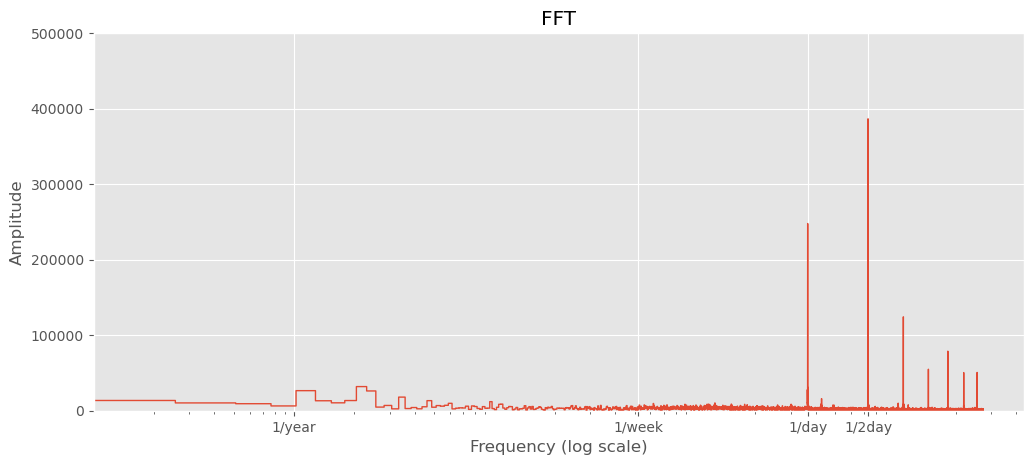

In [184]:
# FFT: Finding relevant seasonalities in high-frequency data
# Configurable: in the Chapter example, a day is 25 half hours
fft = tensorflow.signal.rfft(train_dataset['n_clients'])
f_per_dataset = arange(0, len(fft))

n_samples_h = len(train_dataset['n_clients'])
days_per_year = dataset_day*365.2524
years_per_dataset = n_samples_h/(days_per_year)

print(len(fft), days_per_year, years_per_dataset)

f_per_year = f_per_dataset/years_per_dataset
pyplot.step(f_per_year, np.abs(fft))
pyplot.title("FFT")
pyplot.xscale('log')
pyplot.ylim(0, 500000)
pyplot.xlim([0.1, max(pyplot.xlim())])
pyplot.xticks([1, 52.1428571429, 365.2524, 730.5048], labels=['1/year', '1/week', '1/day', '1/2day'])
_ = pyplot.xlabel('Frequency (log scale)')
pyplot.ylabel('Amplitude')
pyplot.show()

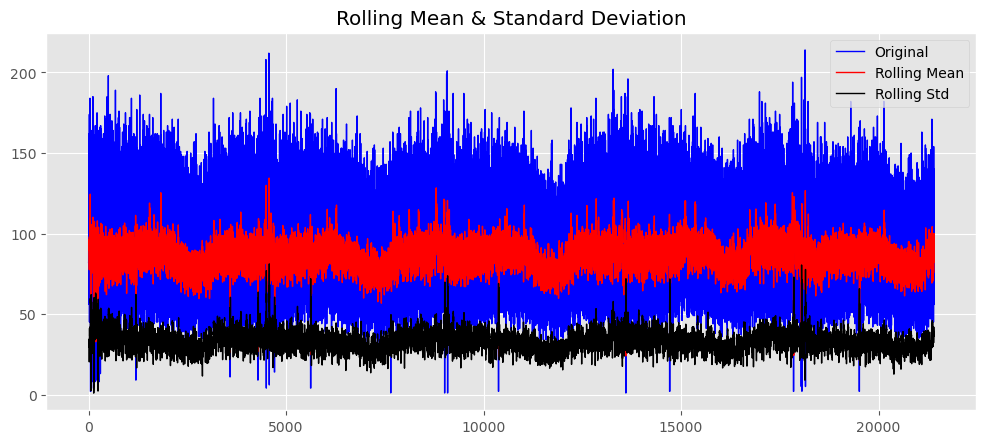

Results of Dickey-Fuller Test:
Test Statistic                -1.336488e+01
p-value                        5.337808e-25
#Lags Used                     4.600000e+01
Number of Observations Used    2.135800e+04
Critical Value (1%)           -3.430656e+00
Critical Value (5%)           -2.861675e+00
Critical Value (10%)          -2.566842e+00
dtype: float64


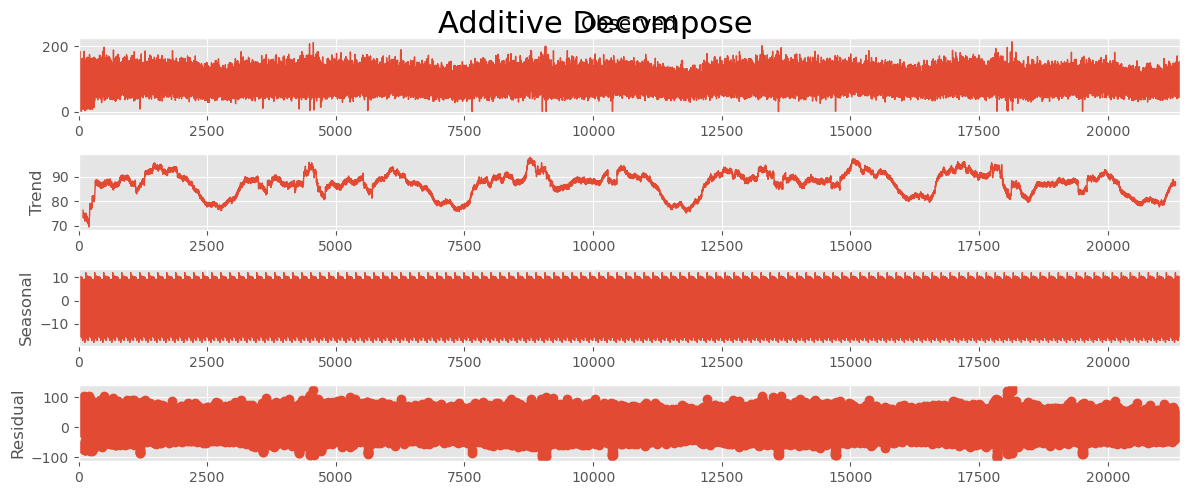

In [185]:
# Check components and stationarity of the forecast variable
forecast_variable = train_dataset['n_clients'].values

# Test stationarity
test_stationarity(forecast_variable)

# Additive Decomposition
result_add = seasonal_decompose(forecast_variable, model='additive', period=175)

# Plot components

result_add.plot().suptitle('Additive Decompose', fontsize=22)
pyplot.show()

In [186]:
#%matplotlib notebook
if remove_components:
    # Remove trend and seasonality, regression with fourier terms!
    forecast_variable = train_dataset.reset_index().drop(['ds'],axis=1)
    print(forecast_variable)

    # Time scale
    predic1 = range(len(train_dataset))
    model_day = True
    model_halfday = True
    model_week = False
    
    # K = 1
    if model_halfday:
        predic_halfday_cos = list(map(lambda x: cos(2*pi*x/(dataset_day/2.0)), predic1))
        predic_halfday_sin = list(map(lambda x: sin(2*pi*x/(dataset_day/2.0)), predic1))
    if model_day:
        #Applying the Fourier terms to the time scale
        predic_day_cos = list(map(lambda x: cos(2*pi*x/dataset_day), predic1))
        predic_day_sin = list(map(lambda x: sin(2*pi*x/dataset_day), predic1))
    if model_week:
        predic_week_cos = list(map(lambda x: cos(2*pi*x/(dataset_day*7)), predic1))
        predic_week_sin = list(map(lambda x: sin(2*pi*x/(dataset_day*7)), predic1))
    
    # Assembling the regressors
    if model_halfday and model_day and model_week: 
        reg = pd.DataFrame(list(zip(predic1, predic_day_cos, predic_day_sin, predic_week_cos, predic_week_sin, predic_halfday_cos, predic_halfday_sin)), 
                columns =['predic1', 'predic_day_cos', 'predic_day_sin', 'predic_week_cos', 'predic_week_sin', 'predic_halfday_cos', 'predic_halfday_sin'])

        # Linear regression
        reg_model = LinearRegression().fit(reg, forecast_variable)

        #The estimated parameters
        r2 = reg_model.score(reg, forecast_variable)
        print('coefficient of determination:', r2)

        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_week = reg_model.coef_[0][3]*array(predic_week_cos) + reg_model.coef_[0][4]*array(predic_week_sin)
        seas_halfday = reg_model.coef_[0][5]*array(predic_halfday_cos) + reg_model.coef_[0][6]*array(predic_halfday_sin)
        trend_seas = trend + seas_day  + seas_week + seas_halfday
    elif model_halfday and model_day and not model_week:
        reg = pd.DataFrame(list(zip(predic1, predic_day_cos, predic_day_sin, predic_halfday_cos, predic_halfday_sin)), 
                columns =['predic1', 'predic_day_cos', 'predic_day_sin', 'predic_halfday_cos', 'predic_halfday_sin'])

        # Linear regression
        reg_model = LinearRegression().fit(reg, forecast_variable)

        #The estimated parameters
        r2 = reg_model.score(reg, forecast_variable)
        print('coefficient of determination:', r2)

        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_halfday = reg_model.coef_[0][3]*array(predic_halfday_cos) + reg_model.coef_[0][4]*array(predic_halfday_sin)
        trend_seas = trend + seas_day  + seas_halfday
    elif not model_halfday and model_day and model_week:
        reg = pd.DataFrame(list(zip(predic1, predic_day_cos, predic_day_sin, predic_week_cos, predic_week_sin)), 
                columns =['predic1', 'predic_day_cos', 'predic_day_sin', 'predic_week_cos', 'predic_week_sin'])

        # Linear regression
        reg_model = LinearRegression().fit(reg, forecast_variable)

        #The estimated parameters
        r2 = reg_model.score(reg, forecast_variable)
        print('coefficient of determination:', r2)

        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_week = reg_model.coef_[0][3]*array(predic_week_cos) + reg_model.coef_[0][4]*array(predic_week_sin)
        trend_seas = trend + seas_day  + seas_week

    

    ax = pd.DataFrame(trend_seas, columns=['trend+seasonalities']).plot(figsize=(20,8))
    forecast_variable.plot(ax=ax,alpha=0.7)

    y_adjusted = array(list(forecast_variable['n_clients'])) - trend_seas
    y_adjusted = pd.DataFrame(y_adjusted, columns=['noise'])
    y_adjusted.plot(figsize=(20,8))
    
    y_adjusted = y_adjusted.set_index(train_dataset.index)
    frames = [train_dataset.assign(n_clients=y_adjusted['noise']), dataset.iloc[-test_set*n_test_sets:]]
    dataset = pd.concat(frames)
    print(dataset)

In [187]:
values = dataset.values
# Encode weekday
if encode_weekday:
    encoder = LabelEncoder()
    values[:, 1] = encoder.fit_transform(values[:, 1])

# ensure all data is float
values = values.astype('float32')

print(values.shape)

(22305, 1)


In [188]:
# split into train and test, leave the last test_set blocks for n_output timesteps
train, test = values[:-test_set*n_test_sets], values[-test_set*n_test_sets:]  
"""
# Normalization
scaler = StandardScaler() #MinMaxScaler(feature_range=(0, 1)) 
train = scaler.fit_transform(train)
test = scaler.transform(test)

#for walkforward
def normalize_train(scaler, train):
    train = scaler.fit_transform(train)
    return train

print(train.shape, test.shape)"""

'\n# Normalization\nscaler = StandardScaler() #MinMaxScaler(feature_range=(0, 1)) \ntrain = scaler.fit_transform(train)\ntest = scaler.transform(test)\n\n#for walkforward\ndef normalize_train(scaler, train):\n    train = scaler.fit_transform(train)\n    return train\n\nprint(train.shape, test.shape)'

In [189]:
# convert history into inputs and outputs - framing to a supervised learning problem
def to_supervised(train, length):
    train = train[~pd.isna(train)]
    train = np.atleast_2d(np.asarray(train))
    if train.shape[0] == 1:
        train = train.T 
    train_x = train[:-1].reshape(1,length,1)
    train_y = train[1:].reshape(1,length,1)

    print(train_x.shape, train_y.shape)
    return train_x, train_y

In [190]:
# make the multi-step forecast
def forecast(model, train, length):
    
    pred_array = np.zeros(test_set).reshape(1,test_set,1)
    X_test_initial = train[1:].reshape(1,length,1)
    #pred_array = model.predict(X_test_initial) if predictions of training samples required
    
    #forecast is created by predicting next future value based on previous predictions
    #print(model.predict(X_test_initial))
    pred_array[:,0,:] = model.predict(X_test_initial)[:,-1:,:]
    
    
    for i in range(test_set-1):
        appending = np.append(X_test_initial[:,i+1:,:],pred_array[:,:i+1,:])
        #print("appending")
        #print(appending.flatten(), appending.shape)
        
        pred = model.predict(appending.reshape(1, length, 1))
        #print("prediction\n")
        #print(pred.flatten(), pred.shape)
        
        pred_array[:,i+1:,:] = pred[:,-1:,:]

    
    return pred_array.flatten()

In [191]:
# invert the scaling
def invTransformTarget(scaler, data):
    dummy = pd.DataFrame(zeros((len(data), scaler.n_features_in_)))
    dummy[0] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns)
    return dummy[0].values

walkforward expanding: 1
total expansions: 1
(1, 21404, 1) (1, 21404, 1)
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 21404, 1)]   0                                            
__________________________________________________________________________________________________
conv1d_272 (Conv1D)             (None, 21404, 32)    96          input_12[0][0]                   
__________________________________________________________________________________________________
activation_98 (Activation)      (None, 21404, 32)    0           conv1d_272[0][0]                 
__________________________________________________________________________________________________
conv1d_274 (Conv1D)             (None, 21404, 1)     32          activation_98[0][0]              
__________________

1/1 [==============================] - 2s 2s/step - loss: 114.8344 - mse: 16750.1348
Epoch 2/8000
1/1 [==============================] - 0s 102ms/step - loss: 113.4361 - mse: 16347.6494
Epoch 3/8000
1/1 [==============================] - 0s 102ms/step - loss: 113.1754 - mse: 16275.0713
Epoch 4/8000
1/1 [==============================] - 0s 119ms/step - loss: 111.9091 - mse: 15869.9102
Epoch 5/8000
1/1 [==============================] - 0s 104ms/step - loss: 111.4132 - mse: 15743.5635
Epoch 6/8000
1/1 [==============================] - 0s 103ms/step - loss: 110.3077 - mse: 15399.0684
Epoch 7/8000
1/1 [==============================] - 0s 111ms/step - loss: 109.7782 - mse: 15250.7334
Epoch 8/8000
1/1 [==============================] - 0s 108ms/step - loss: 109.0631 - mse: 15029.9385
Epoch 9/8000
1/1 [==============================] - 0s 111ms/step - loss: 108.2338 - mse: 14786.1885
Epoch 10/8000
1/1 [==============================] - 0s 118ms/step - loss: 107.5090 - mse: 14568.4512
Epoch

1/1 [==============================] - 0s 112ms/step - loss: 87.5687 - mse: 8985.0684
Epoch 83/8000
1/1 [==============================] - 0s 121ms/step - loss: 87.5851 - mse: 8979.0049
Epoch 84/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.5332 - mse: 8970.8574
Epoch 85/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.5759 - mse: 8989.6250
Epoch 86/8000
1/1 [==============================] - 0s 108ms/step - loss: 87.5356 - mse: 8974.9688
Epoch 87/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.5402 - mse: 8974.8604
Epoch 88/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.6014 - mse: 9000.7539
Epoch 89/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.5630 - mse: 8983.0303
Epoch 90/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.5464 - mse: 8973.2998
Epoch 91/8000
1/1 [==============================] - 0s 109ms/step - loss: 87.5543 - mse: 8980.8496
Epoch 92/8000


1/1 [==============================] - 0s 109ms/step - loss: 87.4278 - mse: 8948.6797
Epoch 164/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.4152 - mse: 8942.0029
Epoch 165/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.4373 - mse: 8951.2451
Epoch 166/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.4155 - mse: 8944.3574
Epoch 167/8000
1/1 [==============================] - 0s 108ms/step - loss: 87.4180 - mse: 8940.4619
Epoch 168/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.4219 - mse: 8942.8291
Epoch 169/8000
1/1 [==============================] - 0s 93ms/step - loss: 87.4276 - mse: 8945.9541
Epoch 170/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.4305 - mse: 8943.7754
Epoch 171/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.4161 - mse: 8944.9648
Epoch 172/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.4348 - mse: 8949.7705
Epoch 

1/1 [==============================] - 0s 106ms/step - loss: 87.3480 - mse: 8920.7295
Epoch 245/8000
1/1 [==============================] - 0s 122ms/step - loss: 87.3464 - mse: 8918.5166
Epoch 246/8000
1/1 [==============================] - 0s 114ms/step - loss: 87.3548 - mse: 8922.9766
Epoch 247/8000
1/1 [==============================] - 0s 108ms/step - loss: 87.3663 - mse: 8927.1445
Epoch 248/8000
1/1 [==============================] - 0s 100ms/step - loss: 87.3676 - mse: 8929.9717
Epoch 249/8000
1/1 [==============================] - 0s 109ms/step - loss: 87.3142 - mse: 8911.4648
Epoch 250/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.3671 - mse: 8928.0420
Epoch 251/8000
1/1 [==============================] - 0s 109ms/step - loss: 87.3584 - mse: 8926.5225
Epoch 252/8000
1/1 [==============================] - 0s 101ms/step - loss: 87.4007 - mse: 8937.3867
Epoch 253/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.3188 - mse: 8913.1846
Epoch

1/1 [==============================] - 0s 111ms/step - loss: 87.3093 - mse: 8910.7676
Epoch 326/8000
1/1 [==============================] - 0s 110ms/step - loss: 87.3225 - mse: 8916.4922
Epoch 327/8000
1/1 [==============================] - 0s 117ms/step - loss: 87.2955 - mse: 8906.4873
Epoch 328/8000
1/1 [==============================] - 0s 108ms/step - loss: 87.3057 - mse: 8908.7256
Epoch 329/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.3274 - mse: 8915.0215
Epoch 330/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.3088 - mse: 8911.8232
Epoch 331/8000
1/1 [==============================] - 0s 115ms/step - loss: 87.3038 - mse: 8907.4727
Epoch 332/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.3115 - mse: 8909.8359
Epoch 333/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.3073 - mse: 8908.8467
Epoch 334/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.2973 - mse: 8907.5488
Epoch

1/1 [==============================] - 0s 106ms/step - loss: 87.2660 - mse: 8898.8027
Epoch 407/8000
1/1 [==============================] - 0s 136ms/step - loss: 87.2699 - mse: 8900.2490
Epoch 408/8000
1/1 [==============================] - 0s 138ms/step - loss: 87.2680 - mse: 8897.3525
Epoch 409/8000
1/1 [==============================] - 0s 148ms/step - loss: 87.2742 - mse: 8899.7393
Epoch 410/8000
1/1 [==============================] - 0s 131ms/step - loss: 87.2762 - mse: 8900.4434
Epoch 411/8000
1/1 [==============================] - 0s 132ms/step - loss: 87.2586 - mse: 8897.0283
Epoch 412/8000
1/1 [==============================] - 0s 122ms/step - loss: 87.2591 - mse: 8896.7031
Epoch 413/8000
1/1 [==============================] - 0s 129ms/step - loss: 87.2727 - mse: 8900.4990
Epoch 414/8000
1/1 [==============================] - 0s 138ms/step - loss: 87.2708 - mse: 8899.3506
Epoch 415/8000
1/1 [==============================] - 0s 157ms/step - loss: 87.2753 - mse: 8901.1045
Epoch

1/1 [==============================] - 0s 102ms/step - loss: 87.2358 - mse: 8890.8633
Epoch 488/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.2376 - mse: 8891.3203
Epoch 489/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.2410 - mse: 8891.6191
Epoch 490/8000
1/1 [==============================] - 0s 101ms/step - loss: 87.2483 - mse: 8894.5010
Epoch 491/8000
1/1 [==============================] - 0s 109ms/step - loss: 87.2406 - mse: 8890.8457
Epoch 492/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.2434 - mse: 8892.6182
Epoch 493/8000
1/1 [==============================] - 0s 108ms/step - loss: 87.2335 - mse: 8888.5283
Epoch 494/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.2352 - mse: 8890.1436
Epoch 495/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.2414 - mse: 8891.5625
Epoch 496/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.2356 - mse: 8890.2178
Epoch

1/1 [==============================] - 0s 102ms/step - loss: 87.2234 - mse: 8887.7686
Epoch 569/8000
1/1 [==============================] - 0s 110ms/step - loss: 87.2207 - mse: 8886.8770
Epoch 570/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.2136 - mse: 8884.5400
Epoch 571/8000
1/1 [==============================] - 0s 116ms/step - loss: 87.2223 - mse: 8887.2314
Epoch 572/8000
1/1 [==============================] - 0s 101ms/step - loss: 87.2156 - mse: 8884.6250
Epoch 573/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.2158 - mse: 8884.3604
Epoch 574/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.2169 - mse: 8885.3330
Epoch 575/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.2166 - mse: 8885.7832
Epoch 576/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.2135 - mse: 8884.6553
Epoch 577/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.2169 - mse: 8885.1807
Epoch

1/1 [==============================] - 0s 123ms/step - loss: 87.1976 - mse: 8880.9434
Epoch 650/8000
1/1 [==============================] - 0s 117ms/step - loss: 87.1989 - mse: 8880.5820
Epoch 651/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.2049 - mse: 8882.4805
Epoch 652/8000
1/1 [==============================] - 0s 125ms/step - loss: 87.2018 - mse: 8881.3887
Epoch 653/8000
1/1 [==============================] - 0s 120ms/step - loss: 87.2002 - mse: 8881.6572
Epoch 654/8000
1/1 [==============================] - 0s 131ms/step - loss: 87.1989 - mse: 8880.9902
Epoch 655/8000
1/1 [==============================] - 0s 101ms/step - loss: 87.1983 - mse: 8880.9043
Epoch 656/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.2031 - mse: 8881.6426
Epoch 657/8000
1/1 [==============================] - 0s 113ms/step - loss: 87.1969 - mse: 8879.8545
Epoch 658/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.2021 - mse: 8881.5850
Epoch

1/1 [==============================] - 0s 112ms/step - loss: 87.1915 - mse: 8879.0312
Epoch 731/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1902 - mse: 8878.6406
Epoch 732/8000
1/1 [==============================] - 0s 112ms/step - loss: 87.1922 - mse: 8879.0361
Epoch 733/8000
1/1 [==============================] - 0s 113ms/step - loss: 87.1931 - mse: 8879.7471
Epoch 734/8000
1/1 [==============================] - 0s 112ms/step - loss: 87.1874 - mse: 8878.2578
Epoch 735/8000
1/1 [==============================] - 0s 130ms/step - loss: 87.1911 - mse: 8879.0576
Epoch 736/8000
1/1 [==============================] - 0s 111ms/step - loss: 87.1884 - mse: 8878.5410
Epoch 737/8000
1/1 [==============================] - 0s 120ms/step - loss: 87.1897 - mse: 8878.5166
Epoch 738/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1909 - mse: 8879.1191
Epoch 739/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.1899 - mse: 8878.7109
Epoch

1/1 [==============================] - 0s 105ms/step - loss: 87.1872 - mse: 8877.8623
Epoch 812/8000
1/1 [==============================] - 0s 114ms/step - loss: 87.1847 - mse: 8877.5547
Epoch 813/8000
1/1 [==============================] - 0s 121ms/step - loss: 87.1860 - mse: 8877.6494
Epoch 814/8000
1/1 [==============================] - 0s 125ms/step - loss: 87.1857 - mse: 8877.6094
Epoch 815/8000
1/1 [==============================] - 0s 127ms/step - loss: 87.1862 - mse: 8877.7432
Epoch 816/8000
1/1 [==============================] - 0s 127ms/step - loss: 87.1835 - mse: 8877.1914
Epoch 817/8000
1/1 [==============================] - 0s 126ms/step - loss: 87.1878 - mse: 8878.1729
Epoch 818/8000
1/1 [==============================] - 0s 117ms/step - loss: 87.1864 - mse: 8877.9072
Epoch 819/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.1834 - mse: 8877.1973
Epoch 820/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1845 - mse: 8877.4727
Epoch

1/1 [==============================] - 0s 102ms/step - loss: 87.1813 - mse: 8876.9385
Epoch 893/8000
1/1 [==============================] - 0s 117ms/step - loss: 87.1829 - mse: 8877.2539
Epoch 894/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1798 - mse: 8876.6699
Epoch 895/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1819 - mse: 8877.0049
Epoch 896/8000
1/1 [==============================] - 0s 132ms/step - loss: 87.1824 - mse: 8877.2256
Epoch 897/8000
1/1 [==============================] - 0s 113ms/step - loss: 87.1829 - mse: 8877.1650
Epoch 898/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.1823 - mse: 8877.0391
Epoch 899/8000
1/1 [==============================] - 0s 110ms/step - loss: 87.1814 - mse: 8876.9326
Epoch 900/8000
1/1 [==============================] - 0s 108ms/step - loss: 87.1833 - mse: 8877.3086
Epoch 901/8000
1/1 [==============================] - 0s 100ms/step - loss: 87.1800 - mse: 8876.6797
Epoch

1/1 [==============================] - 0s 96ms/step - loss: 87.1814 - mse: 8876.9395
Epoch 974/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1818 - mse: 8876.9629
Epoch 975/8000
1/1 [==============================] - 0s 108ms/step - loss: 87.1798 - mse: 8876.7344
Epoch 976/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1792 - mse: 8876.5488
Epoch 977/8000
1/1 [==============================] - 0s 127ms/step - loss: 87.1800 - mse: 8876.6348
Epoch 978/8000
1/1 [==============================] - 0s 118ms/step - loss: 87.1790 - mse: 8876.4902
Epoch 979/8000
1/1 [==============================] - 0s 112ms/step - loss: 87.1816 - mse: 8877.0059
Epoch 980/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1799 - mse: 8876.6074
Epoch 981/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.1808 - mse: 8876.7031
Epoch 982/8000
1/1 [==============================] - 0s 100ms/step - loss: 87.1796 - mse: 8876.5781
Epoch 

1/1 [==============================] - 0s 103ms/step - loss: 87.1786 - mse: 8876.4355
Epoch 1054/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1797 - mse: 8876.6260
Epoch 1055/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1798 - mse: 8876.6094
Epoch 1056/8000
1/1 [==============================] - 0s 109ms/step - loss: 87.1791 - mse: 8876.4971
Epoch 1057/8000
1/1 [==============================] - 0s 115ms/step - loss: 87.1797 - mse: 8876.6553
Epoch 1058/8000
1/1 [==============================] - 0s 121ms/step - loss: 87.1794 - mse: 8876.5723
Epoch 1059/8000
1/1 [==============================] - 0s 114ms/step - loss: 87.1794 - mse: 8876.5322
Epoch 1060/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.1787 - mse: 8876.4443
Epoch 1061/8000
1/1 [==============================] - 0s 99ms/step - loss: 87.1797 - mse: 8876.7158
Epoch 1062/8000
1/1 [==============================] - 0s 97ms/step - loss: 87.1790 - mse: 8876.524

1/1 [==============================] - 0s 104ms/step - loss: 87.1788 - mse: 8876.5039
Epoch 1134/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1784 - mse: 8876.4668
Epoch 1135/8000
1/1 [==============================] - 0s 117ms/step - loss: 87.1764 - mse: 8876.1260
Epoch 1136/8000
1/1 [==============================] - 0s 115ms/step - loss: 87.1782 - mse: 8876.3584
Epoch 1137/8000
1/1 [==============================] - 0s 108ms/step - loss: 87.1782 - mse: 8876.4336
Epoch 1138/8000
1/1 [==============================] - 0s 97ms/step - loss: 87.1789 - mse: 8876.5273
Epoch 1139/8000
1/1 [==============================] - 0s 100ms/step - loss: 87.1785 - mse: 8876.4482
Epoch 1140/8000
1/1 [==============================] - 0s 95ms/step - loss: 87.1776 - mse: 8876.2988
Epoch 1141/8000
1/1 [==============================] - 0s 100ms/step - loss: 87.1786 - mse: 8876.4375
Epoch 1142/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1787 - mse: 8876.442

1/1 [==============================] - 0s 95ms/step - loss: 87.1785 - mse: 8876.4346
Epoch 1214/8000
1/1 [==============================] - 0s 100ms/step - loss: 87.1781 - mse: 8876.3955
Epoch 1215/8000
1/1 [==============================] - 0s 100ms/step - loss: 87.1772 - mse: 8876.2412
Epoch 1216/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.1772 - mse: 8876.2197
Epoch 1217/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.1784 - mse: 8876.4258
Epoch 1218/8000
1/1 [==============================] - 0s 114ms/step - loss: 87.1788 - mse: 8876.4727
Epoch 1219/8000
1/1 [==============================] - 0s 119ms/step - loss: 87.1788 - mse: 8876.4707
Epoch 1220/8000
1/1 [==============================] - 0s 114ms/step - loss: 87.1771 - mse: 8876.2168
Epoch 1221/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.1771 - mse: 8876.2178
Epoch 1222/8000
1/1 [==============================] - 0s 98ms/step - loss: 87.1785 - mse: 8876.429

1/1 [==============================] - 0s 102ms/step - loss: 87.1782 - mse: 8876.3975
Epoch 1294/8000
1/1 [==============================] - 0s 95ms/step - loss: 87.1775 - mse: 8876.2861
Epoch 1295/8000
1/1 [==============================] - 0s 95ms/step - loss: 87.1780 - mse: 8876.3818
Epoch 1296/8000
1/1 [==============================] - 0s 98ms/step - loss: 87.1771 - mse: 8876.2207
Epoch 1297/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.1786 - mse: 8876.4482
Epoch 1298/8000
1/1 [==============================] - 0s 110ms/step - loss: 87.1771 - mse: 8876.2197
Epoch 1299/8000
1/1 [==============================] - 0s 115ms/step - loss: 87.1774 - mse: 8876.2725
Epoch 1300/8000
1/1 [==============================] - 0s 109ms/step - loss: 87.1788 - mse: 8876.4932
Epoch 1301/8000
1/1 [==============================] - 0s 100ms/step - loss: 87.1774 - mse: 8876.2666
Epoch 1302/8000
1/1 [==============================] - 0s 97ms/step - loss: 87.1784 - mse: 8876.4004


1/1 [==============================] - 0s 114ms/step - loss: 87.1782 - mse: 8876.3818
Epoch 1374/8000
1/1 [==============================] - 0s 117ms/step - loss: 87.1768 - mse: 8876.1738
Epoch 1375/8000
1/1 [==============================] - 0s 113ms/step - loss: 87.1783 - mse: 8876.3965
Epoch 1376/8000
1/1 [==============================] - 0s 99ms/step - loss: 87.1785 - mse: 8876.4414
Epoch 1377/8000
1/1 [==============================] - 0s 96ms/step - loss: 87.1782 - mse: 8876.3809
Epoch 1378/8000
1/1 [==============================] - 0s 97ms/step - loss: 87.1775 - mse: 8876.2871
Epoch 1379/8000
1/1 [==============================] - 0s 100ms/step - loss: 87.1780 - mse: 8876.3623
Epoch 1380/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1783 - mse: 8876.3945
Epoch 1381/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1783 - mse: 8876.3936
Epoch 1382/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1783 - mse: 8876.3936

1/1 [==============================] - 0s 94ms/step - loss: 87.1781 - mse: 8876.3613
Epoch 1454/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1779 - mse: 8876.3340
Epoch 1455/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1778 - mse: 8876.3164
Epoch 1456/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.1776 - mse: 8876.2754
Epoch 1457/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1776 - mse: 8876.2754
Epoch 1458/8000
1/1 [==============================] - 0s 121ms/step - loss: 87.1779 - mse: 8876.3340
Epoch 1459/8000
1/1 [==============================] - 0s 114ms/step - loss: 87.1776 - mse: 8876.2852
Epoch 1460/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.1781 - mse: 8876.3594
Epoch 1461/8000
1/1 [==============================] - 0s 97ms/step - loss: 87.1764 - mse: 8876.1182
Epoch 1462/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.1781 - mse: 8876.359

1/1 [==============================] - 0s 117ms/step - loss: 87.1780 - mse: 8876.3457
Epoch 1534/8000
1/1 [==============================] - 0s 112ms/step - loss: 87.1759 - mse: 8876.0664
Epoch 1535/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.1780 - mse: 8876.3457
Epoch 1536/8000
1/1 [==============================] - 0s 96ms/step - loss: 87.1779 - mse: 8876.3506
Epoch 1537/8000
1/1 [==============================] - 0s 98ms/step - loss: 87.1764 - mse: 8876.1260
Epoch 1538/8000
1/1 [==============================] - 0s 97ms/step - loss: 87.1775 - mse: 8876.2598
Epoch 1539/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1778 - mse: 8876.3232
Epoch 1540/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1765 - mse: 8876.1357
Epoch 1541/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1780 - mse: 8876.3447
Epoch 1542/8000
1/1 [==============================] - 0s 116ms/step - loss: 87.1778 - mse: 8876.3232

1/1 [==============================] - 0s 112ms/step - loss: 87.1755 - mse: 8876.0020
Epoch 1614/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1777 - mse: 8876.3135
Epoch 1615/8000
1/1 [==============================] - 0s 111ms/step - loss: 87.1779 - mse: 8876.3301
Epoch 1616/8000
1/1 [==============================] - 0s 112ms/step - loss: 87.1779 - mse: 8876.3301
Epoch 1617/8000
1/1 [==============================] - 0s 115ms/step - loss: 87.1771 - mse: 8876.2217
Epoch 1618/8000
1/1 [==============================] - 0s 114ms/step - loss: 87.1759 - mse: 8876.0518
Epoch 1619/8000
1/1 [==============================] - 0s 124ms/step - loss: 87.1772 - mse: 8876.2275
Epoch 1620/8000
1/1 [==============================] - 0s 120ms/step - loss: 87.1779 - mse: 8876.3301
Epoch 1621/8000
1/1 [==============================] - 0s 116ms/step - loss: 87.1773 - mse: 8876.2549
Epoch 1622/8000
1/1 [==============================] - 0s 108ms/step - loss: 87.1773 - mse: 8876.2

1/1 [==============================] - 0s 105ms/step - loss: 87.1771 - mse: 8876.2168
Epoch 1694/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.1777 - mse: 8876.3027
Epoch 1695/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.1778 - mse: 8876.3145
Epoch 1696/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.1771 - mse: 8876.2168
Epoch 1697/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1769 - mse: 8876.1992
Epoch 1698/8000
1/1 [==============================] - 0s 113ms/step - loss: 87.1778 - mse: 8876.3135
Epoch 1699/8000
1/1 [==============================] - 0s 111ms/step - loss: 87.1771 - mse: 8876.2275
Epoch 1700/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1770 - mse: 8876.2100
Epoch 1701/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1764 - mse: 8876.1162
Epoch 1702/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1769 - mse: 8876.1

1/1 [==============================] - 0s 106ms/step - loss: 87.1776 - mse: 8876.2910
Epoch 1774/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1777 - mse: 8876.2979
Epoch 1775/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1758 - mse: 8876.0332
Epoch 1776/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1777 - mse: 8876.2969
Epoch 1777/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1776 - mse: 8876.2900
Epoch 1778/8000
1/1 [==============================] - 0s 110ms/step - loss: 87.1768 - mse: 8876.1914
Epoch 1779/8000
1/1 [==============================] - 0s 97ms/step - loss: 87.1776 - mse: 8876.2900
Epoch 1780/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.1762 - mse: 8876.1006
Epoch 1781/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1768 - mse: 8876.1914
Epoch 1782/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1763 - mse: 8876.10

1/1 [==============================] - 0s 98ms/step - loss: 87.1762 - mse: 8876.0957
Epoch 1854/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1762 - mse: 8876.0977
Epoch 1855/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1768 - mse: 8876.1865
Epoch 1856/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1775 - mse: 8876.2803
Epoch 1857/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.1770 - mse: 8876.2051
Epoch 1858/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1768 - mse: 8876.1865
Epoch 1859/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1775 - mse: 8876.2783
Epoch 1860/8000
1/1 [==============================] - 0s 122ms/step - loss: 87.1770 - mse: 8876.2061
Epoch 1861/8000
1/1 [==============================] - 0s 108ms/step - loss: 87.1763 - mse: 8876.1016
Epoch 1862/8000
1/1 [==============================] - 0s 97ms/step - loss: 87.1770 - mse: 8876.195

1/1 [==============================] - 0s 107ms/step - loss: 87.1775 - mse: 8876.2676
Epoch 1934/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1775 - mse: 8876.2676
Epoch 1935/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1762 - mse: 8876.0908
Epoch 1936/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.1769 - mse: 8876.1934
Epoch 1937/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.1767 - mse: 8876.1768
Epoch 1938/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.1762 - mse: 8876.0908
Epoch 1939/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.1775 - mse: 8876.2666
Epoch 1940/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1762 - mse: 8876.0908
Epoch 1941/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1769 - mse: 8876.1934
Epoch 1942/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1774 - mse: 8876.2

1/1 [==============================] - 0s 105ms/step - loss: 87.1774 - mse: 8876.2578
Epoch 2014/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1774 - mse: 8876.2568
Epoch 2015/8000
1/1 [==============================] - 0s 106ms/step - loss: 87.1767 - mse: 8876.1719
Epoch 2016/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1774 - mse: 8876.2568
Epoch 2017/8000
1/1 [==============================] - 0s 102ms/step - loss: 87.1774 - mse: 8876.2568
Epoch 2018/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.1768 - mse: 8876.1738
Epoch 2019/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1762 - mse: 8876.0879
Epoch 2020/8000
1/1 [==============================] - 0s 104ms/step - loss: 87.1768 - mse: 8876.1738
Epoch 2021/8000
1/1 [==============================] - 0s 111ms/step - loss: 87.1763 - mse: 8876.1006
Epoch 2022/8000
1/1 [==============================] - 0s 98ms/step - loss: 87.1774 - mse: 8876.25

1/1 [==============================] - 0s 113ms/step - loss: 87.1761 - mse: 8876.0811
Epoch 2094/8000
1/1 [==============================] - 0s 105ms/step - loss: 87.1773 - mse: 8876.2451
Epoch 2095/8000
1/1 [==============================] - 0s 110ms/step - loss: 87.1761 - mse: 8876.0830
Epoch 2096/8000
1/1 [==============================] - 0s 100ms/step - loss: 87.1761 - mse: 8876.0811
Epoch 2097/8000
1/1 [==============================] - 0s 107ms/step - loss: 87.1767 - mse: 8876.1641
Epoch 2098/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1773 - mse: 8876.2441
Epoch 2099/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1761 - mse: 8876.0811
Epoch 2100/8000
1/1 [==============================] - 0s 103ms/step - loss: 87.1773 - mse: 8876.2441
Epoch 2101/8000
1/1 [==============================] - 0s 112ms/step - loss: 87.1773 - mse: 8876.2441
Epoch 2102/8000
1/1 [==============================] - 0s 108ms/step - loss: 87.1773 - mse: 8876.2

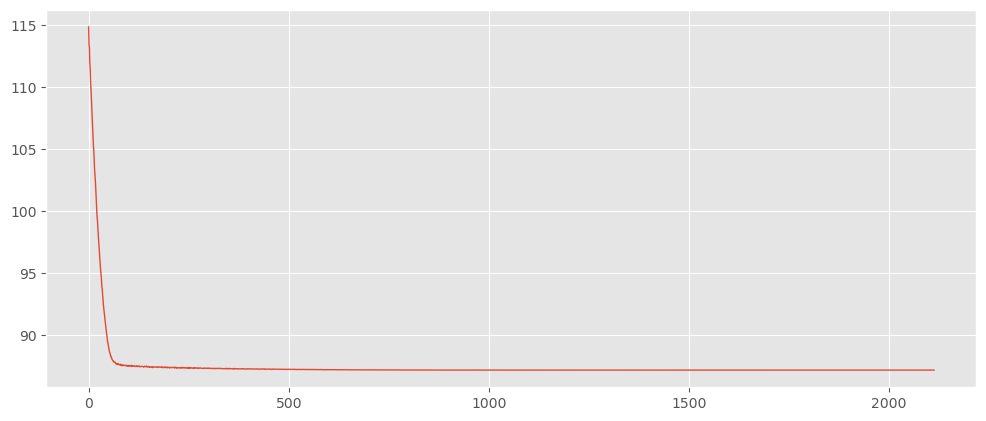

train_size:
21405
The following errors are calculated without the imputed observations!

[13, 14, 28, 29, 43, 44, 58, 59, 73, 74, 88, 89, 103, 104, 118, 119, 133, 134, 148, 149, 163, 164, 178, 179, 193, 194, 208, 209, 223, 224, 238, 239, 253, 254, 268, 269, 276, 277, 278, 279, 280, 281, 282, 283, 284, 298, 299, 313, 314, 328, 329, 343, 344, 358, 359, 373, 374, 388, 389, 403, 404, 418, 419, 433, 434, 448, 449, 463, 464, 478, 479, 493, 494, 508, 509, 523, 524, 538, 539, 553, 554, 568, 569, 583, 584, 598, 599, 613, 614, 628, 629, 643, 644, 658, 659, 673, 674, 688, 689, 703, 704, 718, 719, 733, 734, 748, 749, 763, 764, 778, 779, 793, 794, 808, 809, 823, 824, 838, 839, 853, 854, 868, 869, 883, 884, 898, 899]


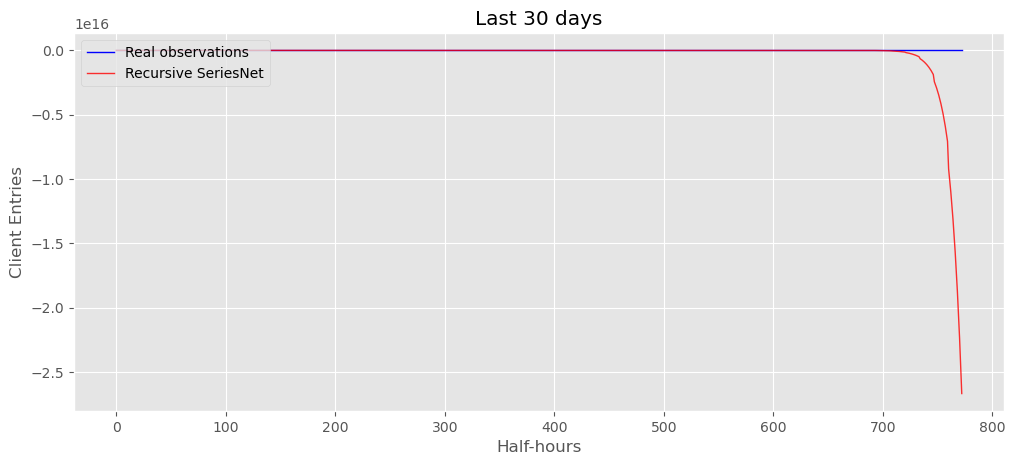

size of target and prediction:
773 773 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [192]:
#%matplotlib notebook
# history of windows, is updated for each prediction
history = [x for x in train]
for i in range(n_test_sets):
    # grid_search hyperparameters?
    # HERE
    
    # Time Series CROSS-VALIDATION
    # we don't need to retrain all the time though!
    print("walkforward expanding: %s" % (i+1))
    print("total expansions: %s" % (n_test_sets))
    # the model is trained and retrained for every number of n_output to predict
    if walkforward or i == 0:
        length = len(history)-1
        model = build_model(array(history), length)  
        train_size = len(history)
        print("train_size:")
        print(train_size)
    
    # predict the next n_output steps
    yhat_sequence = forecast(model, array(history), length)
    test_y = array(test[i*(n_output):(i+1)*(n_output)])
    #print("Test unnormalized error to compare with training loss:")  
    #print(mean_absolute_error(test_y.flatten(), yhat_sequence))
    
    # invert the scaling on predictions
    #yhat_sequence = invTransformTarget(scaler, yhat_sequence)
    
    # invert scaling for real values
    #test_y = invTransformTarget(scaler, test_y)
   
    # give the seasonal and trend components back
    if remove_components:
        # In development!!!
        predic1 = range(train_size, train_size+n_output)
        
        predic_halfday_cos = list(map(lambda x: cos(2*pi*x/(dataset_day/2.0)), predic1))
        predic_halfday_sin = list(map(lambda x: sin(2*pi*x/(dataset_day/2.0)), predic1))
        predic_day_cos = list(map(lambda x: cos(2*pi*x/dataset_day), predic1))
        predic_day_sin = list(map(lambda x: sin(2*pi*x/dataset_day), predic1))
        
        trend = reg_model.intercept_ + reg_model.coef_[0][0]*array(predic1)
        seas_day = reg_model.coef_[0][1]*array(predic_day_cos) + reg_model.coef_[0][2]*array(predic_day_sin)
        seas_halfday = reg_model.coef_[0][3]*array(predic_halfday_cos) + reg_model.coef_[0][4]*array(predic_halfday_sin)
        trend_seas = trend + seas_day  + seas_halfday
        
        sum_components = trend_seas
        yhat_sequence = [yhat_sequence[j]+sum_components[j] for j in range(n_output)]
        
        test_y_append = [test_y[j]-sum_components[j] for j in range(n_output)]
        #test_y_append = scaler.transform(array(test_y_append).reshape(n_output,1))
    

    #RENORMALIZE: after appending the real values back to the training data normalize again to not introduce bias
    """
    if walkforward:
        length = len(history)
        arr_history = array(history)
        arr_history = invTransformTarget(scaler, arr_history.flatten())
        if remove_components:
            history = np.concatenate((history, test_y_append), axis=None)
        else:
            history = np.concatenate((history, test_y), axis=None)
        arr_history = arr_history.reshape(length,n_features)
        arr_history = normalize_train(scaler, arr_history)
        history = list(arr_history.reshape(length, n_features))
    """
    if imputed:
        list_idx = []
        for idx in imputed_idx:
            if train_size-1<idx<train_size+n_output:
                list_idx.append(idx - train_size)
        if list_idx:
            yhat_sequence = np.delete(yhat_sequence,  list_idx)
            test_y = np.delete(test_y,  list_idx)  
            print("The following errors are calculated without the imputed observations!\n")
    
    if compare_imputed:
        list_idx = []
        for idx in remove_idx:
            if train_size-1<idx<train_size+n_output:
                list_idx.append(idx - train_size)
        if list_idx:
            yhat_sequence = np.delete(yhat_sequence,  list_idx)
            test_y = np.delete(test_y,  list_idx) 
            print("The following errors are calculated without observations that do not fit into the wanted schedule!\n")
    print(list_idx)
    # plot each iteration 
    pyplot.title('Last 30 days')
    pyplot.plot(test_y, color="blue", label="Real observations")
    pyplot.plot(yhat_sequence, alpha=0.8, color="red", label="Recursive SeriesNet")
    pyplot.legend(loc="upper left")
    pyplot.xlabel("Half-hours")
    pyplot.ylabel("Client Entries")
    pyplot.show()
    
    print("size of target and prediction:")
    print(len(test_y), len(yhat_sequence), list(yhat_sequence))
    # Score only from the each modelled n_output
    rmse = sqrt(mean_squared_error(test_y, yhat_sequence))
    mae = mean(abs(test_y - yhat_sequence))
    mape = mean(abs(test_y - yhat_sequence) / test_y) * 100
    maape = mean_arctangent_absolute_percentage_error(test_y, yhat_sequence)
    print('Each test score, iteration %s \nRMSE %s' % (i+1, rmse))
    print('MAE %s' % (mae))
    #print('MAPE %s' % (mape))
    print('MAAPE %s \n' % (maape))
    
#plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
#Image('model.png') 
# The question mark means that first dimension is not fixed in the graph and it can vary between run calls
print("The lower visualizations are only useful if walkforward (and multiple predictions) is employed")